In [1]:
from __future__ import print_function

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
# constants for all plots
x_label = '$\lambda$($\mu$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
plot_axis = [0.8, 2.4, 2.8e-15, 4.e-15]

data = np.genfromtxt("data/example_spec_ipac.txt")
wave = data[:,0]
flux = data[:,1]

In [2]:
# two ROIs
indices = (wave > 1.09) & (wave < 2.25) 
w1 = wave[indices]
f1 = flux[indices]
indices = (wave > 0.9) & (wave < 2.35) 
w2 = wave[indices]
f2 = flux[indices]

In [3]:
# build first guesses from the data at hand.
from astropy.modeling import models

def initialize_gaussian(w, f):
    centroid = np.sum(w * f) / np.sum(f)

    dw = w - np.mean(w)
    fwhm = 2 * np.sqrt(np.sum((dw * dw) * f) / np.sum(f))
    sigma = fwhm / 2.355

    delta_w = w[1:] - w[:-1]
    sum_f = np.sum((f[1:] - np.min(f[1:])) * delta_w)
    height = sum_f / (sigma * np.sqrt( 2 * np.pi))
    
    return height, centroid, sigma

def initialize_linear(w, f):
    # compute averages at the 5% of data at each extreme of the wavelength range.
    l = int(len(w) / 20)
    w1 = np.mean(w[0:l])
    w2 = np.mean(w[-l-1:-1])
    f1 = np.mean(f[0:l])
    f2 = np.mean(f[-l-1:-1])
    # fit a straigth line thru these 
    slope = (f2 - f1) / (w2 - w1)
    inter = f2 - slope * w2
    return slope, inter

def initialize_compound(w, f):
    slope, inter = initialize_linear(w, f)
    fc = f - (w * slope + inter)
    height, centroid, sigma = initialize_gaussian(w, fc)
    return height, centroid, sigma, slope, inter

In [4]:
# first guesses
height1, centroid1, sigma1, slope1, inter1 = initialize_compound(w1, f1)
height2, centroid2, sigma2, slope2, inter2 = initialize_compound(w2, f2)

p1 = (height1, centroid1, sigma1, slope1, inter1)
p2 = (height2, centroid2, sigma2, slope2, inter2)

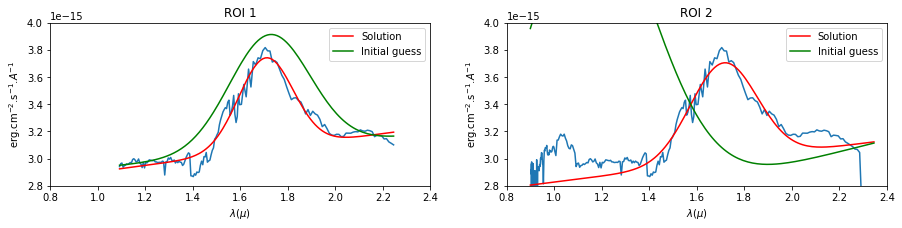

In [5]:
from scipy.optimize import curve_fit

def func(x, a, x0, sigma, slope, intercept):
    return (models.Gaussian1D(amplitude=a, mean=x0, stddev=sigma) + \
            models.Linear1D(slope=slope, intercept=intercept))(x)

# These don't work regardless of the combination of first guesses and 
# methods used. 
# They either raise an exception when reaching maxfev, or just skip
# everything and return the first guesses as the answer. 
# Note that method 'lm' basically calls the same 'leastsq' function
# used by astropy's L-M fitter. It can't deal with bounds though; for
# that, method 'trf' is required.
# popt1, pcov1 = curve_fit(func, w1, f1, p0=p1, method='lm', maxfev=10000)
# popt2, pcov2 = curve_fit(func, w2, f2, p0=p2, method='lm', maxfev=10000)

# Not providing first guesses or method: this will run 'leastsq' as astropy's
# L-M does. It works, but apparently just by chance
popt1, pcov1 = curve_fit(func, w1, f1)
popt2, pcov2 = curve_fit(func, w2, f2)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.plot(w1, func(w1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4]), color='red', label='Solution')
plt.plot(w1, func(w1, p1[0], p1[1], p1[2], p1[3], p1[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, func(w2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]), color='red', label='Solution')
plt.plot(w2, func(w2, p2[0], p2[1], p2[2], p2[3], p2[4]), color='green', label="Initial guess")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("ROI 2")
